# giga-sam

## Environment Setup

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100** or **L4** GPUs when running in Colab.

If running locally, setup a python virtual environment with the `init.sh` script.


In [ ]:
using_colab = False

if using_colab:
    !python3 -m pip install opencv-python matplotlib
    !python3 -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

PyTorch version: 2.9.1+cu128
Torchvision version: 0.24.1+cu128
CUDA is available: False


## Setup

In [2]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from pycocotools.coco import COCO

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.9.1+cu128
Torchvision version: 0.24.1+cu128
CUDA is available: False


## Load the dataset into memory

ATTENTION, only run this once, otherwise your memory will fill up pretty quickly and your computer might crash.

In [3]:
IMAGE_SIZE = 96
IMG_ROOT = os.path.join(os.getcwd(), "../dataset/train2017")
ANN_FILE = os.path.join(os.getcwd(), "../dataset/annotations/instances_train2017.json")


class PicoSAM2Dataset(Dataset):
    def __init__(self, image_dir: str, annotation_file: str, image_size: int):
        self.coco = COCO(annotation_file)
        self.image_dir = image_dir
        self.image_size = image_size
        self.image_ids = self.coco.getImgIds()
        self.annotations = [ann for ann in self.coco.loadAnns(self.coco.getAnnIds(imgIds=self.image_ids)) if ann.get("iscrowd", 0) == 0]
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        ann = self.annotations[index]
        img_info = self.coco.loadImgs(ann['image_id'])[0]
        file_name = img_info.get('file_name', f"{img_info['id']:012d}.jpg")
        img_path = os.path.join(self.image_dir, file_name)

        image = Image.open(img_path).convert("RGB")
        mask = self.coco.annToMask(ann)

        ys, xs = np.where(mask > 0)
        if len(xs) == 0:
            center_x, center_y = image.size[0] // 2, image.size[1] // 2
        else:
            min_x, max_x = xs.min(), xs.max()
            min_y, max_y = ys.min(), ys.max()
            mask_center_x = (min_x + max_x) // 2
            mask_center_y = (min_y + max_y) // 2

            if mask[mask_center_y, mask_center_x]:
                center_x, center_y = mask_center_x, mask_center_y
            else:
                distances = (xs - mask_center_x) ** 2 + (ys - mask_center_y) ** 2
                closest_idx = np.argmin(distances)
                center_x, center_y = xs[closest_idx], ys[closest_idx]

        left = max(0, center_x - self.image_size // 2)
        top = max(0, center_y - self.image_size // 2)
        right = min(image.size[0], left + self.image_size)
        bottom = min(image.size[1], top + self.image_size)

        cropped_img = image.crop((left, top, right, bottom)).resize((self.image_size, self.image_size), Image.BILINEAR)
        cropped_mask = Image.fromarray(mask[top:bottom, left:right]).resize((self.image_size, self.image_size), Image.NEAREST)

        image_tensor = self.transform(cropped_img)
        mask_tensor = torch.tensor(np.array(cropped_mask), dtype=torch.float32).unsqueeze(0)
        prompt_coords = (center_x - left, center_y - top)
        image_id = ann["image_id"]

        datapoint = {
            "image": image,
            "mask": mask,
            "cropped_img": cropped_img,
            "cropped_mask": cropped_mask,
            "image_tensor": image_tensor,
            "mask_tensor": mask_tensor,
            "prompt_coords": prompt_coords,
            "image_id": image_id
        }

        return datapoint

if __name__ == "__main__":
    dataset = PicoSAM2Dataset(IMG_ROOT, ANN_FILE, IMAGE_SIZE)

loading annotations into memory...
Done (t=9.51s)
creating index...
index created!


Mask type: <class 'numpy.ndarray'>
Mask: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Cropped Mask type: <class 'PIL.Image.Image'>
Cropped Mask: <PIL.Image.Image image mode=L size=96x96 at 0x720AE9FCEC60>


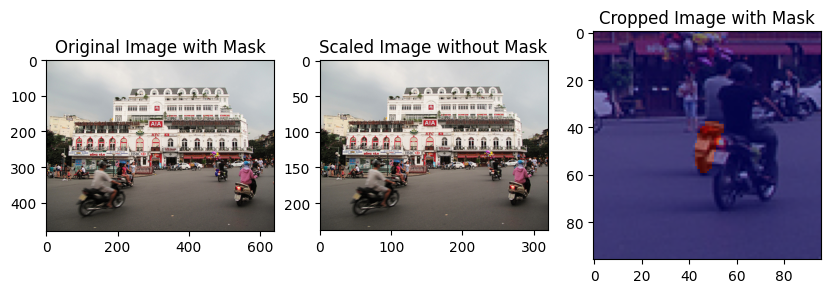

In [ ]:
datapoint = dataset[990]

# bad examples: 30, 90
# could check how large the mask is compared to overall image size and depending on that, scale it first and then crop

# good example: 10, 990
# works good for small masks
   
image = datapoint["image"]
mask = datapoint["mask"]
mask_overlay = np.ma.masked_where(mask == 0, mask)

cropped_img = datapoint["cropped_img"]
cropped_mask = datapoint["cropped_mask"]
cropped_mask_overlay = np.ma.masked_where(cropped_mask == 0, cropped_mask)

print("Mask type:", type(mask))
print("Mask:", mask)

print("Cropped Mask type:", type(cropped_mask))
print("Cropped Mask:", cropped_mask)

# scale the original image and mask
SCALE_FACTOR = 0.5  # 50%
new_width = int(image.size[0] * SCALE_FACTOR)
new_height = int(image.size[1] * SCALE_FACTOR)

scaled_img = image.resize((new_width, new_height), Image.Resampling.LANCZOS)


# plot the original, scaled and cropped images. Overlay a transparent mask on both images
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(image)
axs[0].imshow(mask_overlay, alpha=0.5, cmap='jet', interpolation='none')
axs[0].set_title("Original Image with Mask")
axs[0].axis('on')

axs[1].imshow(scaled_img)
axs[1].set_title("Scaled Image without Mask")
axs[1].axis('on')

axs[2].imshow(cropped_img)
axs[2].imshow(cropped_mask_overlay, alpha=0.5, cmap='jet', interpolation='none')
axs[2].set_title("Cropped Image with Mask")
axs[2].axis('on')

plt.show()